## Intensity Based Registration

The goal of this exercise is to register two images only using their intensity values.      
For example, we have two CT images of the same anatomy and of the same patient taken in two different moments. There will be probably some displacement or rotation between the two images. If we take one of them as the reference image, we can register the second one so that they are aligned.    
This way, for example, it will be easier to evaluate anatomies or structures shown in the two images and their variation over time.

If you didn't get from the lecture, an extremely simplified explanation on how image based registration works is this:
- 1: take two images, one differs from the other
- 2: have a similarity metric that tells you how much they are dis-/similar
- 3: move around one of the two images using some parameters (e.g. rotation angle, displacement in x, displacement in y)
- 4: compute the similarity between these two images (the one that was moved and the fixed one)
- 5: try really really hard to find the parameters for which the difference is minimal (or the similarity is maximal), i.e. run step 3 and 4 with difference parameters changing them using a good strategy.

First things first. Let's load the images that we want to work with.     
*fixed_image* will be the reference one, we will try to register *moving_image* onto it.

In [1]:
from imageio import imread
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2



# Load datasets from file
fixed_image = imread(os.path.join('data', 'ct_fixed.png')).astype('double')
moving_image = imread(os.path.join('data', 'ct_moving.png')).astype('double')


We might want to display the two image and the difference between the two, so that be can visually understand how they differ.      
Let's write a function that does the job.

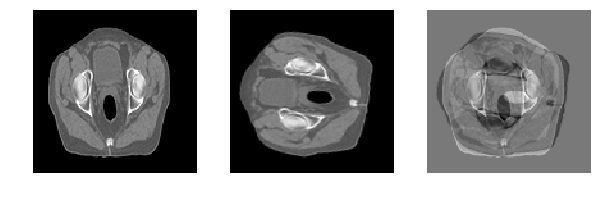

In [2]:



def plot_images(x, y):

    '''Function to display two images and their difference on screen.
    :param x: first image to display
    :param y: second image to display
    :return: void
    '''

    # Creating a figure with subplots of a certain size.
    fig, (plot1, plot2, plot3) = plt.subplots(1, 3, figsize=(10, 3))

    # Display the two images.
    plot1.imshow(x, cmap=plt.cm.gray)
    plot1.axis('off')
    plot2.imshow(y, cmap=plt.cm.gray)
    plot2.axis('off')

    # Computing the difference of the two images and display it.
    diff = x - y
    plot3.imshow(diff, cmap=plt.cm.gray)
    plot3.axis('off')

    plt.show()

# Let's test our function.
plot_images(moving_image, fixed_image)

### Image Manipulation

To register the two images, we need to transform one of them. 
In this section we are going to write some functions to manipulate images, i.e. we need a function to rotate an image and one to translate it.
To write them, you can make use of built-in function contained in OpenCV. No need to reinvent the wheel.

You might need to install OpenCV, run "pip install opencv-python"

##### Toubles installing OpenCV? (Probably on Windows with Python 3.x)
Try to download the right wheel file for your system from here: http://www.lfd.uci.edu/~gohlke/pythonlibs/#opencv    
You can install it using pip. e.g. 'pip install "opencv_python‑3.2.0‑cp35‑cp35m‑win_amd64.whl"' for OpenCV 3.2 and Python 3.5

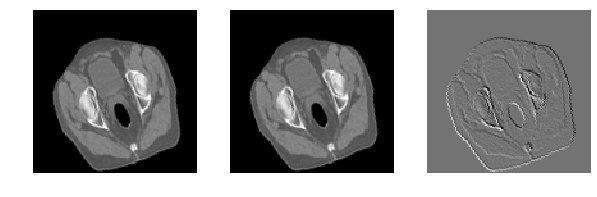

In [3]:
#HINT: OpenCV doc : http://docs.opencv.org/3.2.0/da/d6e/tutorial_py_geometric_transformations.html


def translate_image(x, dx, dy):

    ''' Returns the matrix [x] translated along x and y of [dx] and [dy] respectively.
    :param x: numpy matrix to translate
    :param dx: displacement in x
    :param dy: displacement in y
    :return: the translated matrix
    '''
    
    cols, rows = x.shape  # size of the matrix.

    # A way to build a transformation is to manually enter its values.
    # Here we only need to fill the translational part of a 3x3 matrix.
    transform = np.float32([[1, 0, dx], [0, 1, dy]])

    # Transforms the image with the given transformation.
    # The last parameter gives the size of the output, we want it to be the same of the input.
    return cv2.warpAffine(x, transform,(cols, rows))


def rotate_image(x, angle):

    ''' Returns the matrix [x] rotated counter-clock wise by [angle].
    :param x: numpy matrix to rotate
    :param angle: angle of rotation in DEGREES
    :return: the rotated matrix
    '''

    cols, rows = x.shape  # size of the matrix.

    # Creates a rotation matrix to rotate around a rotation center of a certain angle.
    # In this case we rotate around the center of the image (cols / 2, rows / 2) by the given angle.
    # The last paramters is a scale factor, 1 means no scaling.
    transform = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)

    # Transforms the image with the given transformation.
    # The last parameter gives the size of the output, we want it to be the same of the input.
    return cv2.warpAffine(x, transform, (cols, rows))


def transform_image(x, angle, dx, dy):
    ''' Returns the matrix [x] rotated counter-clock wise by [angle] and translated by [dx] and [dy] in x and y respectively.
    :param x: numpy matrix to transform
    :param angle: angle of rotation in DEGREES
    :param dx:  displacement in x
    :param dy: displacement in y
    :return: the transformed matrix
    '''

    # We just concatenate the functions to rotate and translate, rotation is always done first.
    return translate_image(rotate_image(x, angle), dx, dy)


def transform_image_param(x, parameters):
    '''
    :param x: numpy matrix to transform
    :param parameters: array containing the 3 parameters for the transformation: angle, dx and dy
    :return: the transformed matrix
    '''

    # We just call transform_image unfolding the parameters
    return transform_image(x, parameters[0], parameters[1], parameters[2])

# We load a ground truth, it is moving_image rotated by 20 degrees and translated by (5, 5)
ground_truth_rotation = imread(os.path.join('data', 'ground_truth_rotation.png')).astype('double')
# Let's test the function you just wrote, transform moving_image by the same values
rotation_test = transform_image(moving_image, 20, 5, 5)
# Check if your function is correct
plot_images(rotation_test, ground_truth_rotation[:, :, 1])

### Similarity Metrics

We need a good way to compute how much the two images differ (or how much similar they are).     
You have seen in the lecture that there are multiple ways to compute that. We are going to implement all of them, namely:     

- SSD: Sum of the Square Differences
- SAD: Sum of the Absolute Differences
- NCC: Normalized Cross Correlation
- MI: Mutual Information

The implementation should be straight forward using the formulas from the lecture.    
We are going to write a small function for each metric. After each function you are a small unit test to test your function against a known correct result.

First, we will write the Sum of Squared Differences metric.Do you remember the formula? $$SSD={1\over N} \sum_i (x_i - y_i)^2 $$

In [4]:
def ssd(x, y):
    ''' Returns the sum of the squared differences of the given matrices
    '''
    n, m = y.shape 
    return (1/(n*m)) * np.sum(np.square(x - y))

test_ssd = ssd(moving_image, fixed_image)
ground_truth_ssd = 1514.2839965820312
print("Your SSD answers with: {}. Jack says: {}".format(test_ssd, ground_truth_ssd))

Your SSD answers with: 1514.2839965820312. Jack says: 1514.2839965820312


Now, it is time for the Sum of Absolute Differences: $$SAD={1\over N} \sum_i |x_i - y_i| $$

In [5]:
def sad(x, y):
    ''' Returns the sum of the absolute differences of the given matrices
    '''
    n, m = y.shape
    return (1/(n*m)) * np.sum(np.abs(x - y))

test_sad = sad(moving_image, fixed_image)
ground_truth_sad = 19.36151123046875
print("Your SAD answers with: {}. Jack says: {}".format(test_sad, ground_truth_sad))

Your SAD answers with: 19.36151123046875. Jack says: 19.36151123046875


The Normalized Cross Correlation: $$NCC={1\over N} \sum_i {(x_i - \bar{x})(y_i - \bar{y})\over{\sigma_x \sigma_y}} $$

In [6]:
def ncc(x, y):
    ''' Computes the normalized cross correlation between the given matrices
    '''
    n, m = y.shape

    # Demeaning the matrices.
    x -= np.mean(x)
    y -= np.mean(y)

    # This is the formula as simple as it is.
    # The computation of the standard deviation might not be computationally optimal,
    # but for this exercises we do not care.
    s = (1/(n*m)) * np.sum((x * y) / (x.std() * y.std()))
    return s

test_ncc = ncc(moving_image, fixed_image)
ground_truth_ncc = 0.802228403920768
print("Your NCC answers with: {}. Jack says: {}".format(test_ncc, ground_truth_ncc))

Your NCC answers with: 0.802228403920768. Jack says: 0.802228403920768


And finally, let's implement the Mutual Information metric. For this, remember:
$$H(x) = -\sum_i p_x(i) \log p_x(i)$$ 

$$H(x, y) = -\sum_i \sum_j p_{x,y}(i, j) \log p_{x,y}(i, j)$$

$$MI = H(x) + H(y) - H(x, y)$$

In [7]:
def mi(x, y):
    ''' Computes the mutual information between the given matrices
    '''

    # Compute joint histogram. You may want to use np.histogram2d for this.
    # histogram2d takes 1D vectors, ravel() reshape the matrix to a 1D vector.
    # Don not forget to normalize the histogram in order to get a joint distribution. 
    jh = np.histogram2d(x.ravel(), y.ravel())[0]
    jh = jh + np.finfo(float).eps # add eps for stability

    # Normalize.
    sh = np.sum(jh)
    jh /= sh

    # You can get the individual distributions by marginalization of the joint distribution jh. 
    # We have two random variables x and y whose joint distribution is known,
    # the marginal distribution of X is the probability distribution of X,
    # when the value of Y is not known. And vice versa.
    s1 = np.sum(jh, axis=0, keepdims=True)
    s2 = np.sum(jh, axis=1, keepdims=True)

    # Compute the MI.
    MI = np.sum(-s1 * np.log2(s1)) + np.sum(-s2 * np.log2(s2)) - np.sum(-jh * np.log2(jh))

    return MI

test_mi = mi(moving_image, fixed_image)
ground_truth_mi = 0.74620104021828171
print("Your MI answers with: {}. Jack says: {}".format(test_mi, ground_truth_mi))

Your MI answers with: 0.7462010402182817. Jack says: 0.7462010402182817


### Cost Function

The const function is what we are going to minimize to achieve the registration.     
At each try the cost function will use the two images and the currenct parameters to transform one of the two images.
For that attempt, we will get a similarity value.

This basically composes steps 3 and 4 of the trivial explaination I gave you at the beginning. 

Later we will minimize this cost function. But remember that in the case of NCC and MI, we would like to maximize these metrics. 

In [8]:
def cost_function(transform_params, fixed_image, moving_image, similarity):
    ''' Computes a similarity measure between the given images using the given similarity metric
    :param transform_params: 3 element array with values for rotation, displacement along x axis, dislplacement along y axis.
                             The moving_image will be transformed using these values before the computation of similarity.
    :param fixed_image: the reference image for registration
    :param moving_image: the image to register to the fixed_image
    :param similarity: a string naming the similarity metric to use. e.g. SSD, SAD, ...
    :return: the compute similarity
    '''
    # Build transform parameters
    angle = transform_params[0]
    dx = transform_params[1]
    dy = transform_params[2]
    
    # Transform the moving_image with the current parameters (We already have code for this)
    transformed_moving_img = transform_image(moving_image, angle, dx, dy)
    
    d_moving_image = transformed_moving_img.astype('double')

    # Compute the similarity value using the given method.
    # 
    if similarity == "SSD":
        s = ssd(transformed_moving_img, fixed_image)
    elif similarity == "SAD":
        s = sad(transformed_moving_img, fixed_image)
    elif similarity == "NCC": #Since we want to maximize NCC, we can minimize its negative
        s = -ncc(transformed_moving_img, fixed_image)
    elif similarity == "MI":
        s = -mi(transformed_moving_img, fixed_image) #Since we want to maximize MI, we can minimize its negative
    else:
        print("Wrong similarity measure given.")
        return -1
    return s

### Optimization

We have now an optimization problem, we want to find some values (the transform_params in the previous function) that minimize/maximize the dis-/similarity between the two images.    
There are different approaches to solve the problem, a classical one is using a simplex method.     
To do so, we are going to use the 'fmin' function from Scipy. It implements the Nelder-Mead algorithm : https://en.wikipedia.org/wiki/Nelder–Mead_method

Optimization terminated successfully.
         Current function value: -1.720216
         Iterations: 87
         Function evaluations: 174


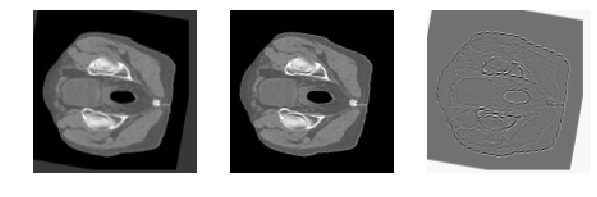

In [13]:
import scipy.optimize

# Give some initial values to the transformation parameters
x0 = [75, -15, -15]

# Choose with similarity metric to use
#similarity_metric = "SSD"
#similarity_metric = "SAD"
#similarity_metric = "NCC"
similarity_metric = "MI"

# Call fmin : https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.fmin.html
# In short fmin needs a function (cost_function) and initial values for the parameters to minimize for (x0),
# what is in args are additional parameters that are needed for our specific function.
# fmin will return the values that after running the algorithm are minimazing the function
result_params = scipy.optimize.fmin(cost_function, x0, args=(fixed_image, moving_image, similarity_metric))

# Transform the moving images with the found parameters 
result_image = transform_image_param(moving_image, result_params)
# Let's have a look at the result!
plot_images(result_image, fixed_image)

*(Based on Jack's original exercise)